# Vision Transformer for Traction Force Microscopy (ViT-TFM)

In [26]:
import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT-TFM/")
sys.path.append(f"{os.getcwd()}/mltfm/")
import VisionTransformer as vit

In [27]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [28]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


## 1. Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised approach: create a matched dataset by simulating the forward operator on clean data.
  2. Train model to reconstruct signal by taking (corrupted) measurements as input.
  3. Generalize to unseen measurements.

## 2. Comparison: CNN from [Kratz et al.](https://www.biorxiv.org/content/biorxiv/early/2022/09/03/2022.09.02.506331.full.pdf) and ViT

This section serves as a 'sanity check' for my ViT architecture modified for TFM. I trained the model on a set of 25.000 clean pairs of (displacement fields, traction fields) for 10 epochs without any hyperparameter tuning.

Load weights of benchmark CNN and my ViT.

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [5]:
path_to_pth = 'ViT-TFM/logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth'

In [6]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

FileNotFoundError: [Errno 2] No such file or directory: 'ViT-TFM/logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth'

In [37]:
cnn_weights = keras.models.load_model('mltfm/models/model_noise_1e-4.h5')

OSError: No file or directory found at mltfm/models/model_noise_1e-4.h5

Load a test set of 25 clean samples. Neither the CNN nor the ViT have seen these during training.

In [29]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

Compute the predictions and losses for each sample.

In [ ]:
vit_weights.eval()
pred_vit, _ = vit_weights(X_test, True)
pred_cnn = cnn_weights.predict(dspl)

In [32]:
loss = torch.nn.MSELoss(reduction='none')

In [ ]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [ ]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

The per sample loss of the ViT is approximately 3x larger than the CNN loss. This could be rooted in the significantly recuced training time of the vanilla ViT (10 epochs) compared to the training time of the tuned CNN (100 epochs).

Visualize the first test sample `test_sample_00`.

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth (test_sample_00)', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## 3. Optimization possibilities

- Transfer learning
- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning: Linear combination of different objectives such as
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameter tuning: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 

## 4. Visualization of attention maps

In this part I visualize the attention maps for two test samples based on the attention rollout principle introduced by [Abnar and Zuidema](https://arxiv.org/pdf/2005.00928.pdf).

In [ ]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [ ]:
_, attn_scores = vit_weights((X_test[0, :, :, :][np.newaxis, ...]), True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=1)
axs[0].set_title('Input (test_sample_00) as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0,0,:,:] **2 + X_test[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (test_sampl_00) as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 2 and column == 11:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(11*8, 2*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][37, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [ ]:
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [ ]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [ ]:
_, attn_scores = vit_weights(torch.tensor(X_test_).double(), True)

In [ ]:
joint_attentions, grid_size = compute_attention_map(attn_scores)

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 10})
        ind += 1

Since the attention rollout method tends to often highlight irrelevant tokens, we do not draw conclusions from these plots at the moment. For later experiments, more advanced approaches to visualize the attention flow in a Transformer model should be considered (e.g. by [Chefer et al.](https://arxiv.org/pdf/2012.09838.pdf)).

## 5. MC Dropout

Enable dropout during inference in the CNN.

In [ ]:
config = cnn_weights.get_config()

for i, layer in enumerate(config['layers']):
    if layer['class_name'] == 'Dropout':
        layer['inbound_nodes'][0][0][-1]['training'] = True
        
cnn_ = keras.Model.from_config(config)
cnn_.load_weights('mltfm/models/model_noise_1e-4.h5')

For both the CNN and ViT, compute `n_forward_passes` for each of the 25 test samples. Note that the CNN contains 6 dropout layers (p=0.1) and the ViT contains 12 dropout layers in the MLP module of each encoder block (p=0.1).

In [ ]:
from main_dist import inference_with_dropout

n_forward_passes = 10

predictions_vit = torch.zeros(25, 10, 2, 104, 104)
predictions_cnn = torch.zeros(25, 10, 2, 104, 104)
for i in range(0, len(X_test)):
    for j in range(0, n_forward_passes):
        predictions_vit[i, j, :, :, :] = inference_with_dropout(vit_weights, X_test[i][np.newaxis, ...], return_attn_scores=False)
        predictions_cnn[i, j, :, :, :] = torch.tensor(np.moveaxis(np.array((cnn_(dspl[i][np.newaxis, ...]))), 3, 1))

Calculate loss per prediction and loss of averaged prediction.

In [ ]:
averaged_pred_vit = 1/n_forward_passes * predictions_vit.sum(dim=1)
averaged_pred_cnn = 1/n_forward_passes * predictions_cnn.sum(dim=1)

losses_vit = torch.zeros(25, 10)
losses_cnn = torch.zeros(25, 10)
for i in range(0, len(X_test)):
    for j in range(0, n_forward_passes):
        losses_vit[i, j] = torch.sum(loss(predictions_vit[i, j], Y_test[i]))
        losses_cnn[i, j] = torch.sum(loss(predictions_cnn[i, j], Y_test[i]))

In [ ]:
loss_mean_per_sample_vit = torch.mean(losses_vit, axis=1)
loss_mean_per_sample_cnn = torch.mean(losses_cnn, axis=1)

In [ ]:
loss_variance_per_sample_vit = torch.var(losses_vit, axis=1)
loss_variance_per_sample_cnn = torch.var(losses_cnn, axis=1)

In [ ]:
avg_test_rmse_vit = torch.mean(loss_mean_per_sample_vit)
avg_test_rmse_cnn = torch.mean(loss_mean_per_sample_cnn)

In [ ]:
avg_test_rmse_cnn

In [ ]:
avg_test_rmse_vit

Compute empirical variances for each predicted value.

In [ ]:
variances_vit = np.var(predictions_vit.detach().numpy(), axis=1)
variances_cnn = np.var(predictions_cnn.detach().numpy(), axis=1)

Plot predicted variances for one in-distribution test sample.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2,2, figsize=(9, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

im = axs[0, 0].imshow(variances_vit[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 0].set_title('test_sample_00: Variance of predictions in x-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[0, 1].imshow(variances_vit[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 1].set_title('test_sample_00: Variance of predictions in y-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 0].imshow(variances_cnn[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 0].set_title('test_sample_00: Variance of predictions in x-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 1].imshow(variances_cnn[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 1].set_title('test_sample_00: Variance of predictions in y-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

Corrupt test samples with Gaussian noise (i.e. create out-of-distribution samples).

In [ ]:
sigma = 1e-3
cov = torch.tensor([[sigma**2,0],[0,sigma**2]])
noise = np.random.multivariate_normal(np.array([0,0]),cov, (len(X_test),104,104))
noisy_test = dspl + noise

In [ ]:
dspl_noisy_ = np.moveaxis(np.array(noisy_test),3 ,1)
X_test_noisy = torch.from_numpy(dspl_noisy_).double()

In [ ]:
noisy_predictions_vit = torch.zeros(1, 10, 2, 104, 104)
noisy_predictions_cnn = torch.zeros(1, 10, 2, 104, 104)
        
noisy_predictions_vit[0, :, :, :, :] = inference_with_dropout(vit_weights, X_test_noisy[0][np.newaxis, ...], return_attn_scores=False)
noisy_predictions_cnn[0, :, :, :, :] = torch.tensor(np.moveaxis(np.array((cnn_(noisy_test[0][np.newaxis, ...]))), 3, 1))

In [ ]:
averaged_pred_vit = 1/n_forward_passes * noisy_predictions_vit.sum(dim=1)
averaged_pred_cnn = 1/n_forward_passes * noisy_predictions_cnn.sum(dim=1)

losses_noisy_vit = torch.zeros(1, 10)
losses_noisy_cnn = torch.zeros(1, 10)
for i in range(0, len(noisy_predictions_vit)):
    for j in range(0, n_forward_passes):
        losses_noisy_vit[i, j] = torch.sum(loss(noisy_predictions_vit[i, j], Y_test[i]))
        losses_noisy_cnn[i, j] = torch.sum(loss(noisy_predictions_cnn[i, j], Y_test[i]))

In [ ]:
loss_mean_per_noisy_sample_vit = torch.mean(losses_vit, axis=1)
loss_mean_per_noisy_sample_cnn = torch.mean(losses_cnn, axis=1)

In [ ]:
variances_noisy_vit = np.var(noisy_predictions_vit.detach().numpy(), axis=1)
variances_noisy_cnn = np.var(noisy_predictions_cnn.detach().numpy(), axis=1)

In [ ]:
loss_of_averaged_vit_pred = torch.sum(loss(averaged_pred_vit, Y_test[0]))
loss_of_averaged_cnn_pred = torch.sum(loss(averaged_pred_cnn, Y_test[0]))

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth (test_sample_00)', {'fontsize': 11})

axs[1, 0].quiver(averaged_pred_vit[0,0,:,:].detach().numpy(), averaged_pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {loss_of_averaged_vit_pred})', {'fontsize': 11})

axs[1, 1].quiver(averaged_pred_cnn[0,0,:,:], averaged_pred_cnn[0,1,:,:], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {loss_of_averaged_cnn_pred})', {'fontsize': 11})

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(9, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

im = axs[0, 0].imshow(variances_noisy_vit[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 0].set_title('test_sample_00: Variance of predictions in x-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[0, 1].imshow(variances_noisy_vit[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[0, 1].set_title('test_sample_00: Variance of predictions in y-plane (ViT)', {'fontsize': 10})
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 0].imshow(variances_noisy_cnn[0, 0, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 0].set_title('test_sample_00: Variance of predictions in x-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = axs[1, 1].imshow(variances_noisy_cnn[0, 1, :, :], cmap='jet', interpolation = 'nearest')
axs[1, 1].set_title('test_sample_00: Variance of predictions in y-plane (CNN)', {'fontsize': 10})
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

Input an all-zero displacement field.

In [ ]:
vit_weights.eval()
all_zeros = torch.zeros(2,104,104).double()

In [ ]:
pred_vit = vit_weights(all_zeros[np.newaxis, ...])

In [ ]:
loss = torch.sum(loss(pred_vit[0], all_zeros))

In [ ]:
loss

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,1, figsize=(6, 6))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs.quiver(pred_vit[0][0,:,:].detach().numpy(), pred_vit[0][1,:,:].detach().numpy(), scale=1)
axs.set_title('Input (test_sample_00)', {'fontsize': 11})

## 6. Transfer learning

In [7]:
from pytorch_pretrained_vit import ViT

Modify training data to match input size.

In [ ]:
import cv2
resized_test_tensor = torch.tensor(resize(X_train[0], dsize=(384, 384), interpolation=cv2.INTER_LINEAR))

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,1, figsize=(4, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs.quiver(resized_test_tensor[:, :, 0].detach().numpy(), resized_test_tensor[:, :, 1].detach().numpy(), scale=3)
axs.set_title('Input (test_sample_00)', {'fontsize': 11})

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,1, figsize=(4, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs.quiver(X_train[0, :, :, 0], X_train[0, :, :, 1], scale=1)
axs.set_title('Input (test_sample_00)', {'fontsize': 11})

Modify `model_pretrained` for downstream task.

In [14]:
from VisionTransformer import RecTracHead, Identity, PretrainedVit

In [19]:
path_pretrained = 'logs_and_weights/ViT-2022-Nov-24 12:43:22/ViT-2022-Nov-24 12:43:22_best_val_loss_0.00021.pth'

In [20]:
vit_pretrained = PretrainedVit(model_pretrained=ViT(name='B_16_imagenet1k', pretrained=True, in_channels=2, num_classes=10).float())
vit_pretrained.load_state_dict(torch.load(path_pretrained)['best_model_weights'], strict=False)

{'dim': 768, 'ff_dim': 3072, 'num_heads': 12, 'num_layers': 12, 'attention_dropout_rate': 0.0, 'dropout_rate': 0.1, 'representation_size': None, 'classifier': 'token', 'patches': (16, 16)}
init call of ViT: height and width of images: 384, 384
init call of ViT: patch sizes: 16, 16
init call of ViT: number of patches: 24, 24
init call of ViT: seq_len: 576
Loaded pretrained weights.


_IncompatibleKeys(missing_keys=[], unexpected_keys=['rec_trac_head.mlp.4.weight', 'rec_trac_head.mlp.4.bias'])

In [30]:
pred_pretrained_vit = vit_pretrained(X_test.float())

In [33]:
loss_pretrained_vit = torch.sum(loss(pred_pretrained_vit, Y_test), (1, 2, 3))
loss_pretrained_vit = torch.reshape(loss_pretrained_vit, (25, 1))

In [34]:
loss_pretrained_vit

tensor([[32.2223],
        [42.8199],
        [66.3372],
        [56.0080],
        [54.1002],
        [65.7070],
        [36.1654],
        [50.4938],
        [44.3282],
        [47.8729],
        [71.7485],
        [85.6927],
        [55.9881],
        [54.7129],
        [67.1759],
        [44.9189],
        [31.6741],
        [26.8165],
        [76.5442],
        [23.3181],
        [23.3448],
        [56.1260],
        [27.5759],
        [65.0170],
        [68.7912]], dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)

Loss on the test set is very high due to insufficient training on a training set of 20 samples only.

<IPython.core.display.Javascript object>


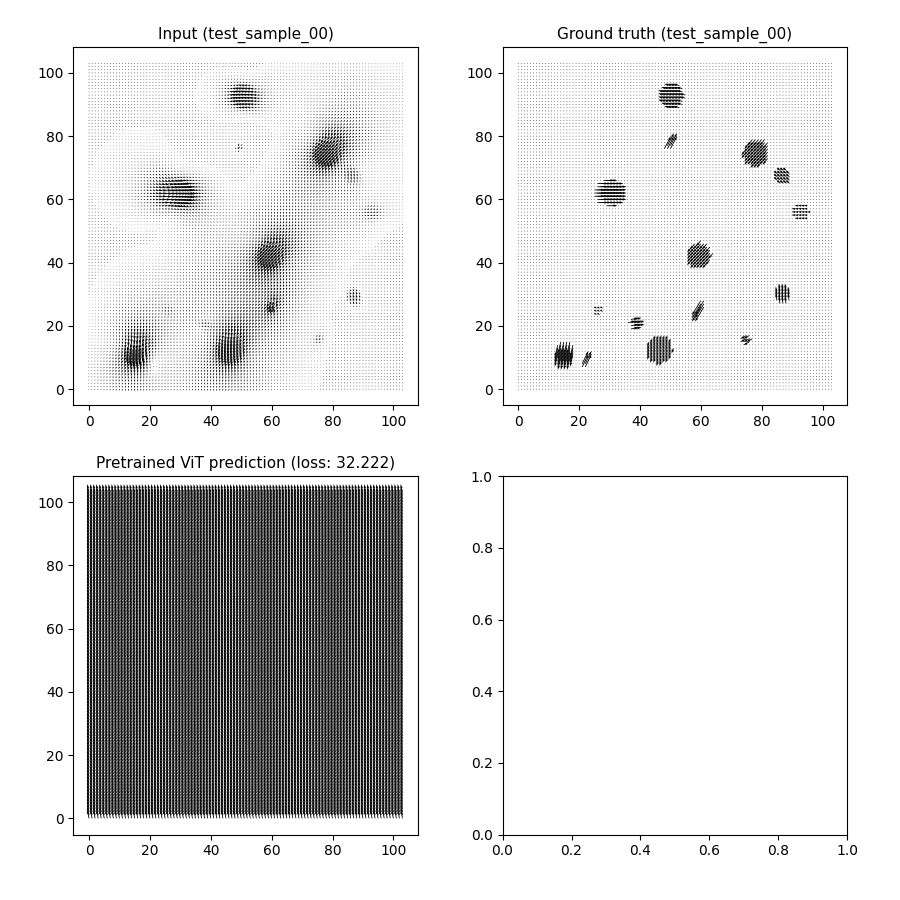

NameError: name 'pred_cnn' is not defined

In [36]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth (test_sample_00)', {'fontsize': 11})

axs[1, 0].quiver(pred_pretrained_vit[0,0,:,:].detach().numpy(), pred_pretrained_vit[0,1,:,:].detach().numpy(), scale=1)
axs[1, 0].set_title(f'Pretrained ViT prediction (loss: {torch.round(loss_pretrained_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

In [ ]:
dspl_train = h5py.File('ViT-TFM/data/displacements_25.h5')["data"]
trac_train = h5py.File('ViT-TFM/data/tractions_25.h5')["data"]

dspl_train_ = np.moveaxis(np.array(dspl),3 ,1)
trac_train_ = np.moveaxis(np.array(trac),3 ,1)

X_train = torch.from_numpy(dspl_train_).float()
Y_train = torch.from_numpy(trac_train_).float()

In [ ]:
"""
mean = variances_vit[:,0,0,0].detach().numpy().mean()
var = variances_vit[:,0,0,0].detach().numpy().var()
gt = test_gt_00[0,0,0,0]


fig, ax = plt.subplots(figsize=(7, 7))
textstr = '\n'.join((
    r'$\mathrm{mean}=%.1e$' % (mean),
    r'$\mathrm{var}=%.1e$' % (var)))
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

counts, bins = np.histogram(stacked_predictions_vit[:,0,0,0].detach().numpy(), bins=50)
max_counts = np.max(counts)
ax.stairs(counts, bins)
ax.hist(bins[:-1], bins, weights=counts, color='dodgerblue', ec='black')
ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
ax.axvline(mean, color='black', linestyle='dashed', linewidth=1)
ax.axvline(gt, color='mediumseagreen', linestyle='dashed', linewidth=1.5, label='ground truth')
ax.text(mean*1.1, 0.85*max_counts, 'mean', rotation=90, fontsize=7)
ax.text(gt*1.12, 0.85*max_counts, 'ground truth', rotation=90, fontsize=7)
ax.set_ylabel('Counts')
ax.set_xlabel('Predicted values');
"""